# Introduction

For this Task we will imagine that we are working in a lab exploring the mechanics of Cas9 binding and cleavage. We will use data from genome-wide screens to develop a novel prediction method. We will then compare this method to the previously published methods.

In [1]:
import sys
sys.path.append('../')
import crisprtree
from crisprtree import utils
from crisprtree import estimators
from crisprtree import annotators
from crisprtree import preprocessing

In [2]:
from Bio import SeqIO
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import glob

sbn.set(style = 'white', font_scale = 1.5)
%matplotlib inline

# Load data

For this example we will use results from a set of GUIDE-Seq experiments by Tsai et al. This methodology allows for an unbaised querying of the in vivo cleavage rates across the entire genome. The relavant files, directly produced by the `guideseq` package, are included in the `data/GUIDESeq` folder.

In [3]:
files = sorted(glob.glob('data/GUIDESeq/*/*.tsv'))

data = pd.concat([pd.read_csv(f, sep='\t').reset_index() for f in files], 
                 axis=0, ignore_index=True)
data.columns = list(data.columns[1:]) + ['_']
data[['Filename', 'BED Name', 'Off-Target Sequence', 'Mismatches', 'bi.sum.mi', 'Target Sequence']].dropna().head()


,Filename,BED Name,Off-Target Sequence,Mismatches,bi.sum.mi,Target Sequence
0,EMX1,chr1_23720618_87,AAGTCCGAGGAGAGGAAGAAAGG,3.0,87,GAGTCCGAGCAGAAGAAGAANGG
9,EMX1,chr10_58848728_2,GAGCACGAGCAAGAGAAGAAGGG,4.0,2,GAGTCCGAGCAGAAGAAGAANGG
21,EMX1,chr13_27769657_8,GAGTAGGAGCAGGAGAAGAAGGA,4.0,8,GAGTCCGAGCAGAAGAAGAANGG
22,EMX1,chr15_44109763_1412,GAGTCTAAGCAGAAGAAGAAGAG,3.0,1412,GAGTCCGAGCAGAAGAAGAANGG
25,EMX1,chr15_100292479_7,AAGTCCCGGCAGAGGAAGAAGGG,4.0,7,GAGTCCGAGCAGAAGAAGAANGG


In [4]:
# we only care about hits
hit_data = data.dropna(subset = ['Off-Target Sequence']).copy() 
# remove ones that are the wrong size
hit_data = hit_data.loc[hit_data['Off-Target Sequence'].map(len) == 23, :].copy() 

# Transform bi.sum.mi into a probability to normalize out the total number of reads per sample
hit_data['NormSum'] = hit_data.groupby('Cells')['bi.sum.mi'].transform(lambda x: x/np.max(x))

# Edit Target Sequence to remove NGG
hit_data['gRNA'] = hit_data['Target Sequence'].map(lambda x: x[:-3])

print('%i observations' % len(hit_data.index))

hit_data[['BED Name', 'Off-Target Sequence', 'Mismatches', 'bi.sum.mi', 'NormSum', 'gRNA']].head()

451 observations


,BED Name,Off-Target Sequence,Mismatches,bi.sum.mi,NormSum,gRNA
0,chr1_23720618_87,AAGTCCGAGGAGAGGAAGAAAGG,3.0,87,0.018786,GAGTCCGAGCAGAAGAAGAA
9,chr10_58848728_2,GAGCACGAGCAAGAGAAGAAGGG,4.0,2,0.000432,GAGTCCGAGCAGAAGAAGAA
21,chr13_27769657_8,GAGTAGGAGCAGGAGAAGAAGGA,4.0,8,0.001727,GAGTCCGAGCAGAAGAAGAA
22,chr15_44109763_1412,GAGTCTAAGCAGAAGAAGAAGAG,3.0,1412,0.304902,GAGTCCGAGCAGAAGAAGAA
25,chr15_100292479_7,AAGTCCCGGCAGAGGAAGAAGGG,4.0,7,0.001512,GAGTCCGAGCAGAAGAAGAA


For this example we want to train a binary classifier (no cleavage vs cleavage) we need to converty the Normalized Sum into a binary response. For simplicity we will use a basic cutoff.

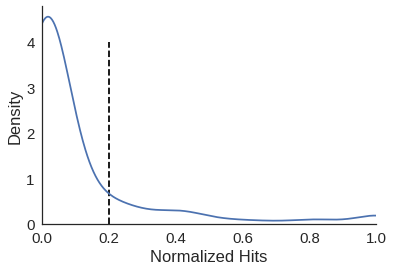

In [5]:
fig, ax = plt.subplots(1,1)

hit_data['NormSum'].plot(kind='kde', ax=ax)
ax.set_xlabel('Normalized Hits')

cutoff = 0.2
ax.vlines(cutoff, 0, 4, linestyle = '--')

ax.set_xlim(0, 1)
ax.set_ylim(0, None)

sbn.despine(ax=ax)

A cutoff of `0.2` will be used to distinguish between cleavage and no cleavage.

# Training a new model

The `preprocessing.MatchingTransformer` converts gRNA-Target pairs into a binary vector that can be used as the input of and `sklearn` module.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

# Convert gRNA-Target pairs into a binary "matching" vector
X = preprocessing.MatchingTransformer().transform(hit_data[['gRNA', 'Off-Target Sequence']].values)
y = (hit_data['NormSum'] >= cutoff).values

# Evaluate the module using 3-fold cross-validation
grad_res = cross_validate(GradientBoostingClassifier(), X, y,
                          scoring = ['accuracy', 'precision', 'recall'],
                          cv = StratifiedKFold(random_state=0),
                          return_train_score=True)
grad_res = pd.DataFrame(grad_res)




# Evaluating built-in models

Since all `estimators` are subclasses of `sklearn` objects, they can be treated in the same way.

In [7]:
# Evaluate MITEstimator using 3-fold cross-validation
mit_res = cross_validate(estimators.MITEstimator(), X, y,
                         scoring = ['accuracy', 'precision', 'recall'],
                         cv = StratifiedKFold(random_state=0),
                         return_train_score=True)
mit_res = pd.DataFrame(mit_res)

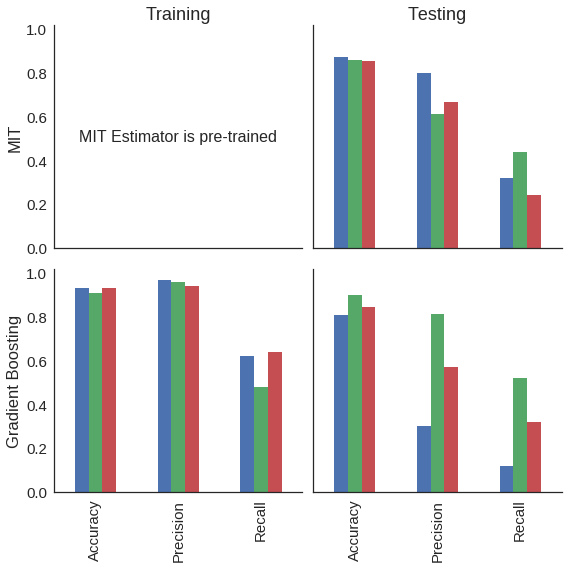

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (8, 8),
                        sharey=True, sharex=True)

order = ['accuracy', 'precision', 'recall']
train_cols = ['train_' + col for col in order]
test_cols = ['test_' + col for col in order]

for row, (name, df) in enumerate([('MIT', mit_res), 
                                  ('Gradient Boosting', grad_res)]):
    
    train_ax, test_ax = axs[row, :]
    
    if row != 0:
        df[train_cols].T.plot(kind='bar', ax=train_ax, legend=False)
    else:
        train_ax.annotate('MIT Estimator is pre-trained',
                          xy = (0.5, 0.5), va = 'center', ha='center',
                          xycoords = 'axes fraction', fontsize = 16)
    df[test_cols].T.plot(kind='bar', ax=test_ax, legend=False)
    
    if train_ax.is_first_row():
        train_ax.set_title('Training')
        test_ax.set_title('Testing')
    else:
        train_ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'])
        test_ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'])
        
    train_ax.set_ylabel(name)
    sbn.despine(ax=train_ax)
    sbn.despine(ax=test_ax)

fig.tight_layout()

A Gradient Boosting model (using default parameters) has comparable accuracy and precision but lower recall when compared with the original MIT method.

# Training multiple models

Using the same strategy, it is trivial to train other classifiers using the same data.

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Train different multiple different models
models = [('GradientBoost', GradientBoostingClassifier()),
          ('Neighbors', KNeighborsClassifier(n_neighbors=10)),
          ('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(100, 10),
                                          random_state = 50,
                                          learning_rate = 'adaptive')),
         ]

for name, model in models:
    classif = model.fit(X, y)
    hit_data[name] = classif.predict_proba(X)[:, 1]

In [10]:

# Evaluate the built-in models on the same data.
ests = [('MIT', estimators.MITEstimator.build_pipeline()),
        ('CFD', estimators.CFDEstimator.build_pipeline()),
        ('Kinetic', estimators.KineticEstimator.build_pipeline())]

for name, est in ests:
    hit_data[name] = est.predict_proba(hit_data[['gRNA', 'Off-Target Sequence']].values)
    
hit_data[['BED Name', 'Mismatches', 'NormSum', 'MIT', 'CFD', 'Kinetic', 'GradientBoost', 'Neighbors']].head()

,BED Name,Mismatches,NormSum,MIT,CFD,Kinetic,GradientBoost,Neighbors
0,chr1_23720618_87,3.0,0.018786,0.137229,0.163333,0.000151,0.104572,0.1
9,chr10_58848728_2,4.0,0.000432,0.190404,0.225064,0.000036,0.083170,0.2
21,chr13_27769657_8,4.0,0.001727,0.000000,0.012940,0.000000,0.051218,0.3
22,chr15_44109763_1412,3.0,0.304902,0.000000,0.240741,0.000000,0.734942,0.4
25,chr15_100292479_7,4.0,0.001512,0.101767,0.211750,0.000217,0.176817,0.4


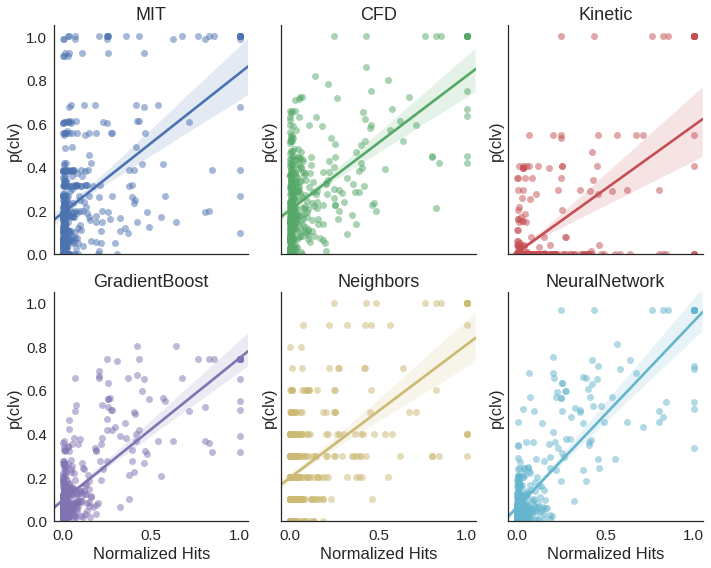

In [11]:
from sklearn.metrics import mean_absolute_error

fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

cols = ['MIT', 
        'CFD', 
        'Kinetic',
        'GradientBoost', 
        'Neighbors',
        'NeuralNetwork']

mabs = {}

for ax, col in zip(axs.flatten(), cols):
    
    sbn.regplot(data = hit_data,
                x = 'NormSum', y = col,
                ax = ax,
                scatter_kws = {'alpha': 0.5})
    error = mean_absolute_error(hit_data['NormSum'], hit_data[col])
    mabs[col] = error
    ax.set_ylim(0, 1.05)
    sbn.despine(ax=ax)
    if col != 'Mismatches':
        ax.set_title(col)
        ax.set_ylabel('p(clv)')
    
    if not ax.is_last_row():
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Normalized Hits')
    
fig.tight_layout()

error = pd.Series(mabs)


From this data we can see that, qualitatively, the newly trained methods perform as well as previously published methods.

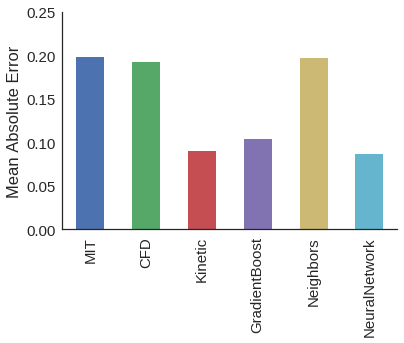

In [12]:
fig, ax = plt.subplots(1,1)
order = ['MIT', 'CFD', 'Kinetic', 'GradientBoost', 'Neighbors', 'NeuralNetwork']
error[order].plot(kind='bar', ax=ax)
ax.set_ylabel('Mean Absolute Error')
ax.set_ylim(0, 0.25)
sbn.despine(ax=ax)

Gradient Boosting and Neural Network models can "outperform" the previously published when measuring the `mean absolute error` between prediction and observation. This implies that there may be an advantage to using more advanced learning techniques.

However, keep in mind: 
 1. We're training on only 451 observations for 21 features. There may be some degree of over-fitting.
 2. These models were trained on all 451 observations. There is no held-out dataset for this analysis.
 3. We have only used data from one experiment. Training a rubust model requires multiple data sources.